In [ ]:
!pip install keras

# !pip install keras==2.15.0
# import keras
# print(keras.version)

In [ ]:
# 비행기 데이터 사용
!git clone https://github.com/1297rohit/RCNN.git

Cloning into 'RCNN'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 19 (from 1)
Receiving objects: 100% (25/25), 12.60 MiB | 44.64 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!unzip /content/RCNN/Images.zip
!unzip /content/RCNN/Airplanes_Annotations.zip

Archive:  /content/RCNN/Images.zip
   creating: Images/
  inflating: Images/airplane_007.jpg  
  inflating: Images/airplane_006.jpg  
  inflating: Images/airplane_005.jpg  
  inflating: Images/airplane_004.jpg  
  inflating: Images/airplane_003.jpg  
  inflating: Images/airplane_002.jpg  
  inflating: Images/airplane_001.jpg  
  inflating: Images/428503.jpg       
  inflating: Images/428501.jpg       
  inflating: Images/428492.jpg       
  inflating: Images/428491.jpg       
  inflating: Images/428483.jpg       
  inflating: Images/428482.jpg       
  inflating: Images/428481.jpg       
  inflating: Images/428472.jpg       
  inflating: Images/428462.jpg       
  inflating: Images/428461.jpg       
  inflating: Images/428452.jpg       
  inflating: Images/428451.jpg       
  inflating: Images/42850.jpg        
  inflating: Images/42849.jpg        
  inflating: Images/42848.jpg        
  inflating: Images/42847.jpg        
  inflating: Images/airplane_309.jpg  
  inflating: Images/airp

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
path = "Images"
annot = "Airplanes_Annotations"

## Bounding Box annotation

airplane_118.jpg


<ipython-input-6-a50648c74246>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-6-a50648c74246>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-6-a50648c74246>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-6-a50648c74246>:11: FutureWarning: Series.__getitem__ treating keys as positio

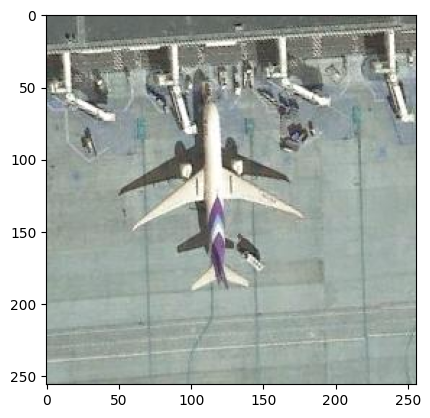

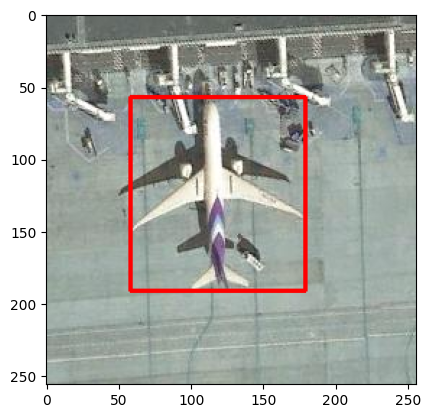

In [ ]:
for i in os.listdir(annot):
    filename = i.split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    plt.imshow(img)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

## Region Proposal 추출

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

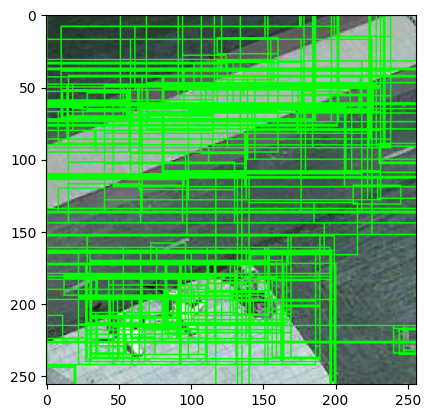

In [ ]:
# airplane_294.jpg 이미지 예시
im = cv2.imread(os.path.join(path,"airplane_294.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1)
# plt.figure()
plt.imshow(imOut)

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top) # 교집합

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # 교집합 / 합집합
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_118.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

1 airplane_251.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

2 airplane_080.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

3 airplane_550.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

4 airplane_328.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
5 airplane_380.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

6 airplane_396.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

7 airplane_455.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

8 airplane_084.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

9 airplane_170.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

10 airplane_055.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

11 airplane_410.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

12 airplane_398.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

13 airplane_158.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

14 airplane_334.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

15 airplane_111.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

16 airplane_067.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

17 airplane_332.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
18 airplane_643.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

19 airplane_588.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

20 airplane_355.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

21 airplane_286.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

22 airplane_140.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

23 airplane_641.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

24 airplane_685.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

25 airplane_447.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

26 airplane_018.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

27 airplane_271.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

28 airplane_089.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

29 airplane_156.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

30 airplane_016.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

31 airplane_438.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

32 airplane_448.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

33 airplane_350.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

34 airplane_653.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

35 airplane_342.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

36 airplane_650.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

37 airplane_506.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

38 airplane_174.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

39 airplane_626.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

40 airplane_167.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

41 airplane_599.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

42 airplane_175.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

43 airplane_428.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

44 airplane_590.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
45 airplane_093.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

46 airplane_505.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

47 airplane_434.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
48 airplane_435.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

49 airplane_409.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

50 airplane_059.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

51 airplane_634.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

52 airplane_135.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

53 airplane_338.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
54 airplane_487.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
55 airplane_037.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

56 airplane_241.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

57 airplane_313.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

58 airplane_235.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

59 airplane_128.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

60 airplane_169.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

61 airplane_554.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

62 airplane_423.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

63 airplane_095.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

64 airplane_576.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

65 airplane_379.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

66 airplane_633.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

67 airplane_228.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

68 airplane_485.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

69 airplane_237.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

70 airplane_679.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

71 airplane_119.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
72 airplane_294.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

73 airplane_408.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

74 airplane_471.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

75 airplane_579.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

76 airplane_282.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

77 airplane_401.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

78 airplane_496.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

79 airplane_215.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

80 airplane_445.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

81 airplane_645.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
82 airplane_431.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

83 airplane_608.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

84 airplane_302.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

85 airplane_049.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

86 airplane_663.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

87 airplane_263.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

88 airplane_449.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

89 airplane_356.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

90 airplane_065.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

91 airplane_660.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

92 airplane_541.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

94 airplane_525.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

95 airplane_047.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

97 airplane_404.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

98 airplane_615.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

99 airplane_395.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

100 airplane_518.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

101 airplane_295.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

102 airplane_317.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

104 airplane_665.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

105 airplane_172.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

106 airplane_099.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

107 airplane_333.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

108 airplane_392.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

109 airplane_377.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
110 airplane_077.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

112 airplane_674.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

113 airplane_598.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

114 airplane_585.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

115 airplane_076.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

116 airplane_122.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

117 airplane_220.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

118 airplane_113.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

119 airplane_420.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

120 airplane_469.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
121 airplane_528.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

122 airplane_069.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

123 airplane_581.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

124 airplane_045.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
125 airplane_284.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

126 airplane_531.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

127 airplane_566.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

128 airplane_264.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
129 airplane_565.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

130 airplane_630.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

131 airplane_330.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

132 airplane_116.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

133 airplane_413.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

134 airplane_104.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

135 airplane_378.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

136 airplane_023.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

137 airplane_177.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

138 airplane_196.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

139 airplane_640.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

141 airplane_361.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

142 airplane_311.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

143 airplane_670.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

144 airplane_242.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

145 airplane_255.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

146 airplane_256.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

147 airplane_134.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

148 airplane_620.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

149 airplane_083.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
150 airplane_029.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

152 airplane_210.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

153 airplane_086.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

154 airplane_535.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

155 airplane_164.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

156 airplane_204.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

157 airplane_303.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

158 airplane_621.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
159 airplane_446.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

160 airplane_114.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

161 airplane_510.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

162 airplane_437.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

164 airplane_493.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

165 airplane_229.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

166 airplane_261.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

167 airplane_567.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

168 airplane_467.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

169 airplane_150.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

170 airplane_225.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
171 airplane_569.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

172 airplane_698.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

173 airplane_622.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

174 airplane_515.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

175 airplane_058.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

176 airplane_001.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
177 airplane_106.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

179 airplane_013.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

180 airplane_628.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

182 airplane_021.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

183 airplane_072.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

184 airplane_523.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

185 airplane_041.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
186 airplane_544.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

187 airplane_314.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

188 airplane_019.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

189 airplane_234.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

190 airplane_247.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

191 airplane_376.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

192 airplane_165.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

193 airplane_346.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

194 airplane_232.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

196 airplane_678.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

197 airplane_125.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

198 airplane_091.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

199 airplane_287.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

200 airplane_214.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
201 airplane_490.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

202 airplane_244.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

204 airplane_109.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

206 airplane_348.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

207 airplane_537.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

208 airplane_249.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

211 airplane_430.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

212 airplane_351.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

213 airplane_132.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

214 airplane_138.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

215 airplane_366.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

216 airplane_233.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

217 airplane_563.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

218 airplane_178.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

220 airplane_316.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

221 airplane_275.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

222 airplane_432.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

223 airplane_443.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

224 airplane_183.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

225 airplane_412.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

226 airplane_558.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

227 airplane_130.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

228 airplane_502.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

229 airplane_649.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

230 airplane_687.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

231 airplane_143.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

232 airplane_474.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

233 airplane_208.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

234 airplane_463.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

235 airplane_068.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

236 airplane_248.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

237 airplane_677.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

238 airplane_221.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

239 airplane_039.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

241 airplane_078.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

242 airplane_024.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

243 airplane_597.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

244 airplane_283.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

245 airplane_273.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

247 airplane_201.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

248 airplane_681.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

249 airplane_100.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

250 airplane_075.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
251 airplane_296.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

252 airplane_593.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
253 airplane_349.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

254 airplane_623.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

255 airplane_553.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
256 airplane_306.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
257 airplane_344.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

259 airplane_012.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
260 airplane_127.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

261 airplane_149.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

262 airplane_606.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

263 airplane_071.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

264 airplane_508.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

265 airplane_131.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

266 airplane_421.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

267 airplane_202.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

268 airplane_532.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

269 airplane_006.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

270 airplane_497.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
271 airplane_499.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

272 airplane_181.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

273 airplane_185.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

274 airplane_406.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

275 airplane_651.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

276 airplane_511.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

277 airplane_529.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

278 airplane_274.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

279 airplane_399.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

280 airplane_004.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
281 airplane_030.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

282 airplane_227.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

283 airplane_584.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

284 airplane_425.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

285 airplane_661.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

286 airplane_015.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

287 airplane_186.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

288 airplane_387.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

289 airplane_667.jpg
290 airplane_224.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

291 airplane_017.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

293 airplane_682.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

294 airplane_035.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

295 airplane_173.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

298 airplane_586.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

299 airplane_516.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

300 airplane_363.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

301 airplane_484.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

303 airplane_246.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

304 airplane_637.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

305 airplane_266.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

306 airplane_675.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

307 airplane_146.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

308 airplane_098.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

309 airplane_151.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
310 airplane_389.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

311 airplane_159.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

312 airplane_386.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

313 airplane_347.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
314 airplane_504.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
315 airplane_222.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

316 airplane_527.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

317 airplane_577.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

318 airplane_061.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

319 airplane_354.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

320 airplane_375.jpg
321 airplane_509.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

322 airplane_176.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

323 airplane_108.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
324 airplane_384.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

325 airplane_184.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

326 airplane_120.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
327 airplane_666.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

328 airplane_407.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

329 airplane_368.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

330 airplane_155.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

331 airplane_276.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
332 airplane_081.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

333 airplane_121.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
335 airplane_352.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

336 airplane_397.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

337 airplane_236.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

338 airplane_439.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

339 airplane_466.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

340 airplane_673.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

341 airplane_063.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

342 airplane_648.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

343 airplane_103.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

344 airplane_309.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

345 airplane_602.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

346 airplane_153.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

347 airplane_549.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

348 airplane_556.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

349 airplane_600.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

350 airplane_672.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

352 airplane_374.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

353 airplane_694.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

354 airplane_609.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

355 airplane_290.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

356 airplane_345.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

357 airplane_635.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

358 airplane_693.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

359 airplane_371.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

360 airplane_483.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

361 airplane_391.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

362 airplane_699.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

363 airplane_087.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

364 airplane_388.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
365 airplane_444.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

366 airplane_564.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

367 airplane_115.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

368 airplane_671.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

369 airplane_521.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

370 airplane_205.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

371 airplane_517.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

372 airplane_403.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

373 airplane_238.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

374 airplane_105.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

375 airplane_583.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

376 airplane_010.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

377 airplane_278.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

378 airplane_676.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

379 airplane_056.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

380 airplane_259.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

381 airplane_193.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

382 airplane_571.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

383 airplane_382.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
384 airplane_038.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

385 airplane_028.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

386 airplane_538.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

387 airplane_548.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

388 airplane_329.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

389 airplane_281.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

390 airplane_187.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

391 airplane_629.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

392 airplane_044.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

393 airplane_683.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

394 airplane_459.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

395 airplane_617.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

396 airplane_422.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

397 airplane_418.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

398 airplane_009.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

399 airplane_464.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

400 airplane_200.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

401 airplane_252.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

402 airplane_123.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
403 airplane_533.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

404 airplane_066.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

405 airplane_500.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

406 airplane_070.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

407 airplane_543.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

408 airplane_307.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

409 airplane_475.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

410 airplane_441.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

411 airplane_357.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

412 airplane_512.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

413 airplane_213.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
414 airplane_373.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
415 airplane_014.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

416 airplane_367.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

417 airplane_336.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

418 airplane_206.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

419 airplane_652.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

420 airplane_419.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
421 airplane_616.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
422 airplane_304.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

423 airplane_689.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

424 airplane_513.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

425 airplane_322.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

426 airplane_442.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

427 airplane_638.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
428 airplane_192.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

429 airplane_477.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

430 airplane_209.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

431 airplane_203.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

432 airplane_458.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

433 airplane_604.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

434 airplane_260.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

435 airplane_573.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

436 airplane_136.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
437 airplane_580.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

438 airplane_212.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

439 airplane_289.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
440 airplane_473.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

441 airplane_162.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

442 airplane_339.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

443 airplane_144.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

444 airplane_636.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

445 airplane_454.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

446 airplane_627.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

447 airplane_481.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

449 airplane_182.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

450 airplane_057.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

451 airplane_429.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

452 airplane_700.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

453 airplane_631.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

454 airplane_478.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

455 airplane_416.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

456 airplane_297.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
457 airplane_340.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

458 airplane_526.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
459 airplane_335.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

460 airplane_020.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

461 airplane_141.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

462 airplane_050.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

463 airplane_381.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

464 airplane_539.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

465 airplane_277.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

466 airplane_610.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

467 airplane_219.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

468 airplane_393.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

469 airplane_312.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

470 airplane_315.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
471 airplane_190.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
472 airplane_257.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

473 airplane_595.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

474 airplane_461.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

475 airplane_102.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

476 airplane_417.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

477 airplane_680.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

478 airplane_647.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

479 airplane_157.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

480 airplane_540.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

481 airplane_697.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

482 airplane_269.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

483 airplane_096.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
484 airplane_092.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

485 airplane_240.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

487 airplane_199.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
488 airplane_326.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
489 airplane_489.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

490 airplane_323.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

491 airplane_457.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

492 airplane_300.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

493 airplane_074.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

494 airplane_321.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

495 airplane_688.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

496 airplane_197.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

497 airplane_033.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

498 airplane_129.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

500 airplane_601.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

501 airplane_618.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

502 airplane_258.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

503 airplane_365.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

504 airplane_027.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

505 airplane_433.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

506 airplane_053.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
507 airplane_460.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

508 airplane_519.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

509 airplane_318.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

510 airplane_005.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
511 airplane_292.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

512 airplane_310.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

513 airplane_591.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

514 airplane_218.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

515 airplane_166.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

516 airplane_239.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

517 airplane_148.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

518 airplane_293.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

519 airplane_305.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
520 airplane_040.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

521 airplane_003.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

522 airplane_090.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

523 airplane_390.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

524 airplane_230.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

525 airplane_657.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

526 airplane_394.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

527 airplane_574.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

528 airplane_625.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

529 airplane_385.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
530 airplane_551.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
531 airplane_179.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

532 airplane_152.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

533 airplane_520.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

534 airplane_079.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

535 airplane_112.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
536 airplane_007.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
537 airplane_424.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

538 airplane_452.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
539 airplane_470.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

540 airplane_440.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

541 airplane_570.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

542 airplane_582.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

543 airplane_559.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

544 airplane_658.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
545 airplane_530.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

546 airplane_552.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

547 airplane_198.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

548 airplane_082.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

549 airplane_507.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

550 airplane_644.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

551 airplane_324.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

552 airplane_669.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

553 airplane_492.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

554 airplane_226.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

555 airplane_690.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

556 airplane_624.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
557 airplane_696.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

558 airplane_414.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

559 airplane_285.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

560 airplane_656.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

562 airplane_453.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

563 airplane_126.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
564 airplane_288.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

565 airplane_002.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

566 airplane_161.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

567 airplane_472.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

568 airplane_545.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

569 airplane_243.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

570 airplane_605.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

571 airplane_211.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

572 airplane_180.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

573 airplane_194.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

574 airplane_522.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

575 airplane_299.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

576 airplane_046.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

577 airplane_364.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

578 airplane_476.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

579 airplane_133.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

580 airplane_491.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

581 airplane_360.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

582 airplane_488.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

583 airplane_054.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

584 airplane_684.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

585 airplane_137.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
586 airplane_486.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

587 airplane_611.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

588 airplane_032.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

589 airplane_062.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
590 airplane_524.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

591 airplane_557.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

592 airplane_026.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

593 airplane_405.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

594 airplane_008.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

595 airplane_308.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

596 airplane_337.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

597 airplane_188.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

598 airplane_268.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

599 airplane_254.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

600 airplane_245.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

601 airplane_495.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

602 airplane_171.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

603 airplane_223.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
604 airplane_578.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

605 airplane_482.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

606 airplane_267.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

607 airplane_319.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

609 airplane_594.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

610 airplane_568.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
611 airplane_400.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

612 airplane_450.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

613 airplane_301.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
614 airplane_088.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

615 airplane_101.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

616 airplane_147.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

617 airplane_195.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

618 airplane_587.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

619 airplane_291.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
620 airplane_426.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

621 airplane_160.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

622 airplane_265.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

623 airplane_692.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

624 airplane_655.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

625 airplane_632.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

626 airplane_547.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

627 airplane_341.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

628 airplane_613.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

629 airplane_031.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

630 airplane_025.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

633 airplane_085.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
634 airplane_662.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

635 airplane_372.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

636 airplane_691.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

637 airplane_036.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

638 airplane_189.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

639 airplane_603.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

640 airplane_411.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

641 airplane_612.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

642 airplane_427.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
643 airplane_110.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

644 airplane_325.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

645 airplane_154.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

646 airplane_546.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

647 airplane_043.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

648 airplane_064.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

649 airplane_494.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

650 airplane_436.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

651 airplane_503.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

652 airplane_107.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

653 airplane_659.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

654 airplane_060.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

655 airplane_668.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

656 airplane_468.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

657 airplane_501.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

658 airplane_094.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

659 airplane_327.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

660 airplane_343.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
661 airplane_383.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
662 airplane_695.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

663 airplane_642.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

664 airplane_664.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

665 airplane_542.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

666 airplane_250.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

667 airplane_279.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

668 airplane_168.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

670 airplane_619.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
671 airplane_369.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

672 airplane_592.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

673 airplane_596.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
674 airplane_331.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

675 airplane_639.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

676 airplane_614.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

677 airplane_358.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

678 airplane_034.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

679 airplane_048.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

680 airplane_480.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

681 airplane_465.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

682 airplane_207.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

683 airplane_462.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

684 airplane_124.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

685 airplane_117.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

686 airplane_362.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
687 airplane_498.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

688 airplane_555.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
689 airplane_536.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

690 airplane_145.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

691 airplane_320.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

692 airplane_589.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

693 airplane_298.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

694 airplane_562.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

695 airplane_097.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
696 airplane_607.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

697 airplane_139.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

698 airplane_253.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

699 airplane_456.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

700 airplane_646.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

701 airplane_353.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

702 airplane_231.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

703 airplane_575.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

704 airplane_051.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

705 airplane_561.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

inside
706 airplane_073.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

707 airplane_370.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

708 airplane_217.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

709 airplane_359.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

710 airplane_262.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

711 airplane_572.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

712 airplane_479.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

713 airplane_163.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

714 airplane_216.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

715 airplane_142.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

716 airplane_560.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

717 airplane_451.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

718 airplane_191.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

719 airplane_402.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

720 airplane_415.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

721 airplane_686.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

723 airplane_052.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

724 airplane_280.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

725 airplane_022.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

726 airplane_514.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

727 airplane_042.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

728 airplane_270.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

729 airplane_011.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

730 airplane_654.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

731 airplane_534.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

732 airplane_272.jpg


<ipython-input-12-5224745ce0e2>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
<ipython-input-12-5224745ce0e2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
<ipython-input-12-5224745ce0e2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
<ipython-input-12-5224745ce0e2>:13: FutureWarning: Series.__getitem__ treating keys as p

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)
print(X_new.shape)
print(y_new.shape)

(30229, 224, 224, 3)
(30229,)


In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [ ]:
X = vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
vggmodel.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>

In [ ]:
model_final = Model(vggmodel.input,predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 126,633,474 (483.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27206, 224, 224, 3)
(3023, 224, 224, 3)
(27206, 2)
(3023, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "ieeercnn_vgg16_1.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=1
)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit(
    traindata,
    steps_per_epoch= 10,
    epochs= 100,
    validation_data= testdata,
    validation_steps=2,
    callbacks=[checkpoint,early]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2:06 14s/step - accuracy: 0.5938 - loss: 1.1005

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:199: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6419 - loss: 1.7790 - val_accuracy: 0.7344 - val_loss: 0.5729
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.8052 - loss: 0.4145 - val_accuracy: 0.9219 - val_loss: 0.2848
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.8982 - loss: 0.3449 - val_accuracy: 0.8750 - val_loss: 0.3301
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.8654 - loss: 0.3193 - val_accuracy: 0.8125 - val_loss: 0.3126
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.9488 - loss: 0.1895 - val_accuracy: 0.9219 - val_loss: 0.1392
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.9359 - loss: 0.1936 - val_accuracy: 0.8906 - val_loss: 0.2813
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.9663 - loss: 0.1342 - val_accuracy: 0.9062 - val_loss: 0.3096
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.8909 - loss: 0.2463 - val_accuracy: 0.937

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.9643 - loss: 0.1089 - val_accuracy: 0.9375 - val_loss: 0.1730
Epoch 50/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.9754 - loss: 0.1015 - val_accuracy: 0.9688 - val_loss: 0.0792
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.9234 - loss: 0.1781 - val_accuracy: 0.9375 - val_loss: 0.1682
Epoch 52/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.9605 - loss: 0.1250 - val_accuracy: 0.9844 - val_loss: 0.0817
Epoch 53/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.9791 - loss: 0.0710 - val_accuracy: 0.9375 - val_loss: 0.1184
Epoch 54/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.9732 - loss: 0.0959 - val_accuracy: 0.9375 - val_loss: 0.1372
Epoch 55/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.9299 - loss: 0.2213 - val_accuracy: 0.9688 - val_loss: 0.1191
Epoch 56/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.9623 - loss: 0.1247 - val_accuracy:

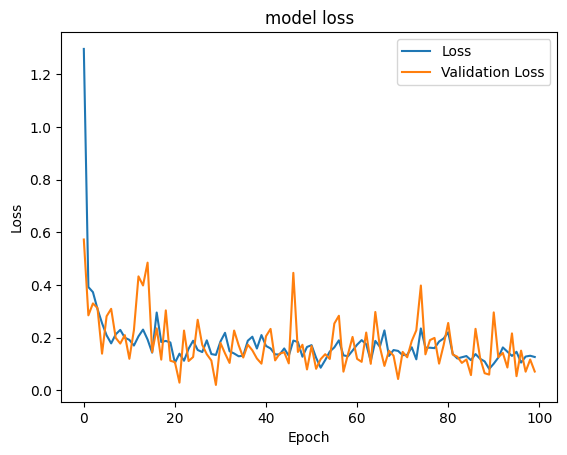

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
img2 = cv2.resize(img,(224,224))
img2 = img2.reshape(1,224,224,3)
img2

array([[[[ 98, 105, 102],
         [ 99, 106, 103],
         [100, 107, 104],
         ...,
         [107, 113, 108],
         [109, 115, 110],
         [106, 112, 107]],

        [[ 99, 106, 103],
         [ 99, 106, 103],
         [100, 107, 104],
         ...,
         [107, 113, 108],
         [108, 113, 108],
         [106, 111, 106]],

        [[ 99, 106, 103],
         [100, 107, 104],
         [100, 107, 104],
         ...,
         [103, 107, 102],
         [103, 108, 103],
         [103, 107, 102]],

        ...,

        [[162, 174, 168],
         [163, 175, 169],
         [163, 175, 170],
         ...,
         [164, 180, 173],
         [159, 175, 168],
         [153, 169, 162]],

        [[166, 176, 170],
         [164, 175, 169],
         [164, 174, 168],
         ...,
         [159, 175, 168],
         [166, 182, 175],
         [149, 165, 158]],

        [[158, 168, 162],
         [155, 165, 159],
         [152, 162, 156],
         ...,
         [158, 174, 167],
        

In [ ]:
out= model_final.predict(img2)
out.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(1, 2)

In [ ]:
out

array([[1.8252957e-05, 9.9998176e-01]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
plane


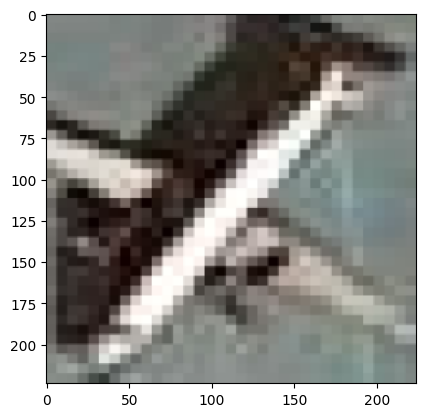

In [ ]:
im = X_test[823]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

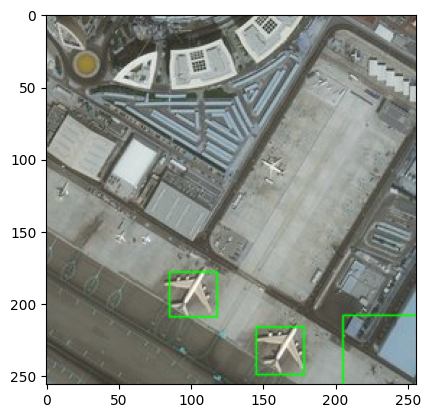

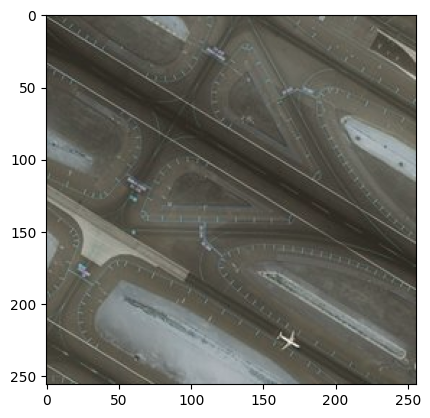

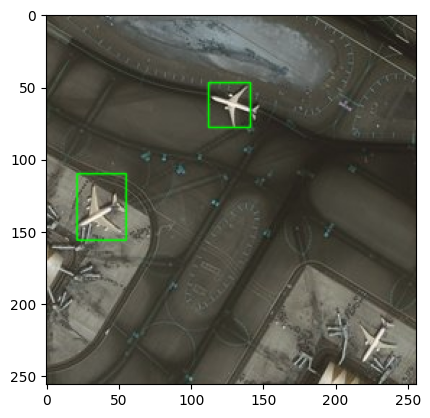

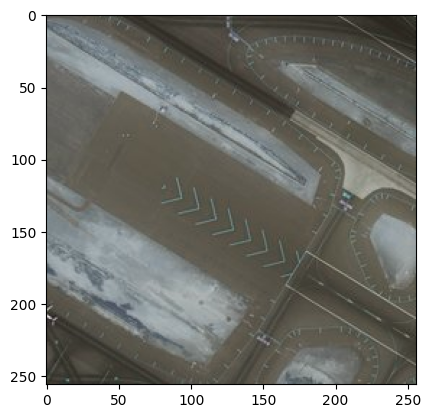

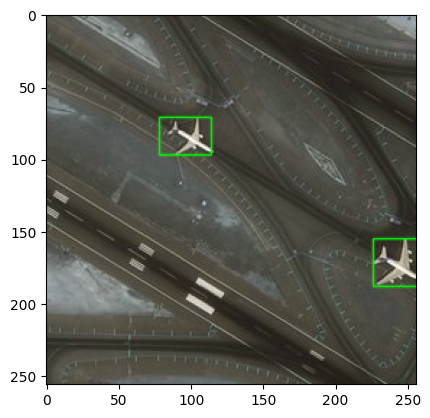

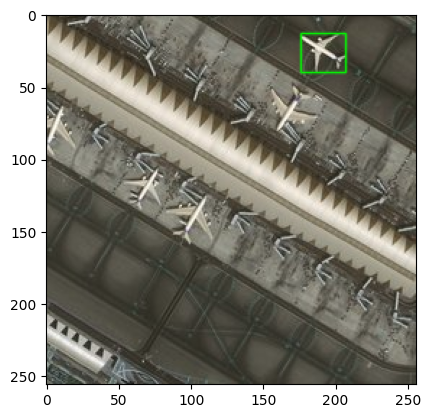

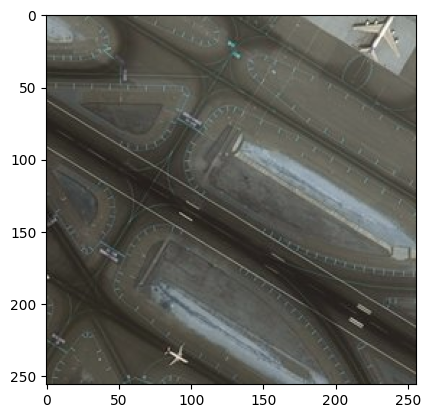

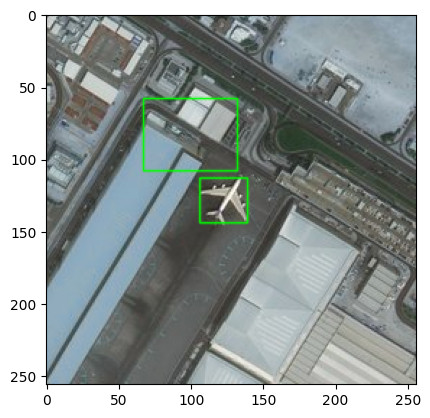

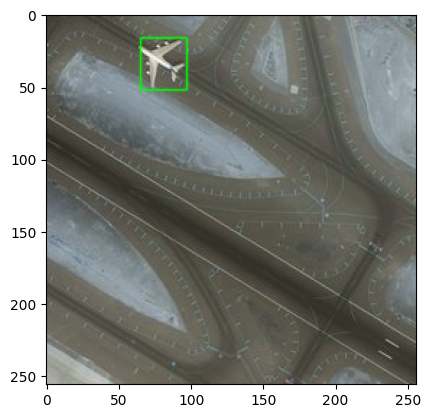

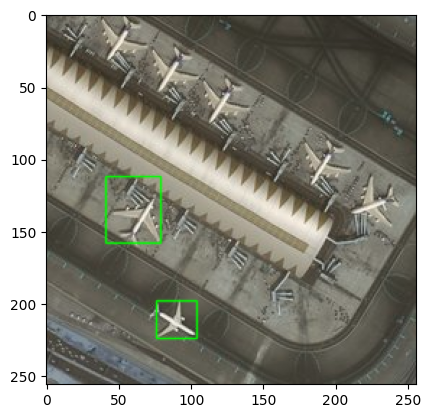

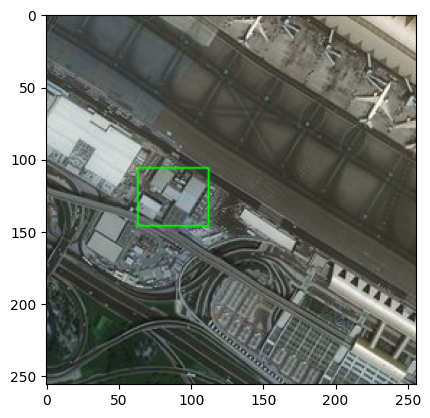

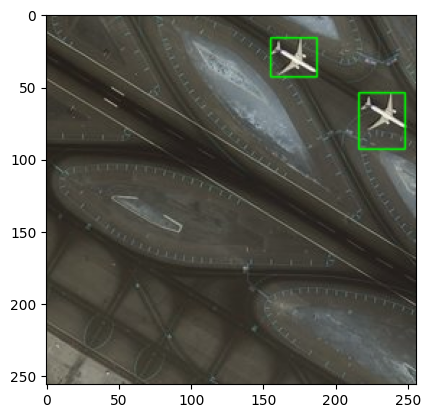

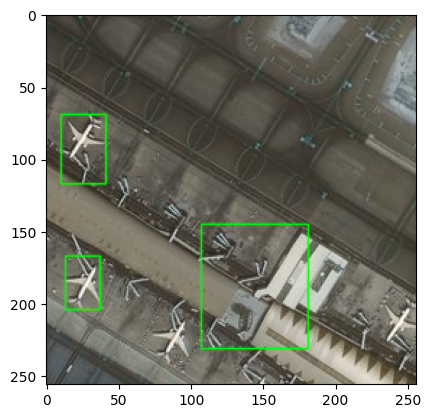

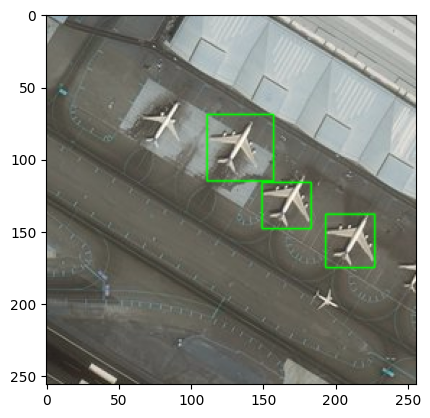

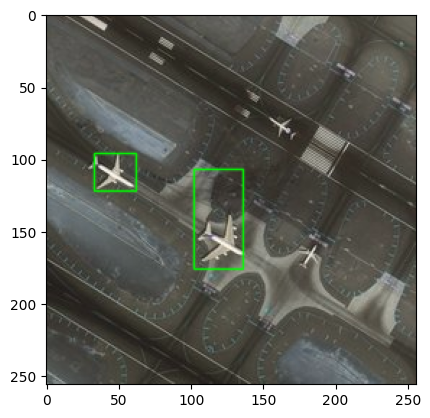

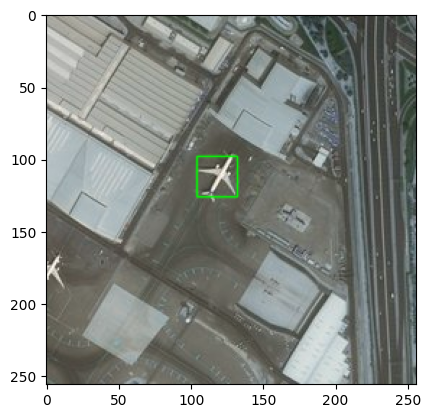

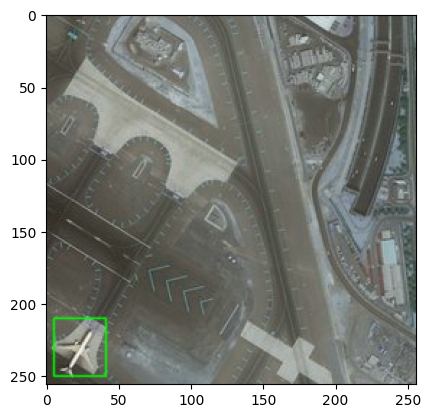

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)